# **Postnatal depression in women**

In this project, we aim to build a predictive model to estimate risk of suicide attempt in women who have recently given birth. We utilize a dataset provided by MD Parvez Mosaraf, whom gathered a dataset of 1503 records from a medical hospital using a questionnaire administered through a Google form. 

Our approach involves preprocessing the data, exploring the data through visualizations, and then applying a machine learning model - specifically, a Random Forest Classifier. We also evaluate the model's performance and visualize the results to gain insights into the model's accuracy and the importance of each feature in predicting risk of suicide attempt.

**Data Source**
[PostPartum Depression dataset from Kaggle](https://www.kaggle.com/datasets/parvezalmuqtadir2348/postpartum-depression)

**Data Dictionary**

|Variable|Key|
|:---|:---|
|Timestamp| mm/dd/yyyy hh:mm
|Age|25-30, 30-35, 35-40, 40-45, 45-50
|Feeling sad or tearful|yes, no, sometimes
|Irritable towards baby & partner|yes, no, sometimes
|Trouble sleeping at night|yes, no, two or more days a week
|Problems concentrating or making decision|yes, no, often
|Overeating or loss of appetite|yes, no, not at all
|Feeling anxious|yes, no
|Feeling of guilt|yes, no, maybe
|Problems of bonding with baby|yes, no, sometimes
|Suicide attempt|yes, no, not interested to say

## Reading data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import display

In [2]:
df = pd.read_csv("data/post_natal_data.csv", delimiter=',', encoding='utf8')
df.head()

,Timestamp,Age,Feeling sad or Tearful,Irritable towards baby & partner,Trouble sleeping at night,Problems concentrating or making decision,Overeating or loss of appetite,Feeling anxious,Feeling of guilt,Problems of bonding with baby,Suicide attempt
0,6/14/2022 20:02,35-40,Yes,Yes,Two or more days a week,Yes,Yes,Yes,No,Yes,Yes
1,6/14/2022 20:03,40-45,Yes,No,No,Yes,Yes,No,Yes,Yes,No
2,6/14/2022 20:04,35-40,Yes,No,Yes,Yes,Yes,Yes,No,Sometimes,No
3,6/14/2022 20:05,35-40,Yes,Yes,Yes,Yes,No,Yes,Maybe,No,No
4,6/14/2022 20:06,40-45,Yes,No,Two or more days a week,Yes,No,Yes,No,Yes,No


In [3]:
df.shape

(1503, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Timestamp                                  1503 non-null   object
 1   Age                                        1503 non-null   object
 2   Feeling sad or Tearful                     1503 non-null   object
 3   Irritable towards baby & partner           1497 non-null   object
 4   Trouble sleeping at night                  1503 non-null   object
 5   Problems concentrating or making decision  1491 non-null   object
 6   Overeating or loss of appetite             1503 non-null   object
 7   Feeling anxious                            1503 non-null   object
 8   Feeling of guilt                           1494 non-null   object
 9   Problems of bonding with baby              1503 non-null   object
 10  Suicide attempt                     

## Data Preparation

In [5]:
# Renaming columns
df = df.rename(columns=lambda x: x.lower().replace(' ', '_'))
df.columns

Index(['timestamp', 'age', 'feeling_sad_or_tearful',
       'irritable_towards_baby_&_partner', 'trouble_sleeping_at_night',
       'problems_concentrating_or_making_decision',
       'overeating_or_loss_of_appetite', 'feeling_anxious', 'feeling_of_guilt',
       'problems_of_bonding_with_baby', 'suicide_attempt'],
      dtype='object')

In [6]:
# Check empty cells
df.isnull().sum()

timestamp                                     0
age                                           0
feeling_sad_or_tearful                        0
irritable_towards_baby_&_partner              6
trouble_sleeping_at_night                     0
problems_concentrating_or_making_decision    12
overeating_or_loss_of_appetite                0
feeling_anxious                               0
feeling_of_guilt                              9
problems_of_bonding_with_baby                 0
suicide_attempt                               0
dtype: int64

In [7]:
# Drop empty cells
df = df.dropna(subset=['irritable_towards_baby_&_partner']).reset_index(drop=True)
df = df.dropna(subset=['problems_concentrating_or_making_decision']).reset_index(drop=True)
df.isnull().sum()

timestamp                                    0
age                                          0
feeling_sad_or_tearful                       0
irritable_towards_baby_&_partner             0
trouble_sleeping_at_night                    0
problems_concentrating_or_making_decision    0
overeating_or_loss_of_appetite               0
feeling_anxious                              0
feeling_of_guilt                             0
problems_of_bonding_with_baby                0
suicide_attempt                              0
dtype: int64

In [8]:
# Drop timestamp column
df = df.drop('timestamp', axis=1)

In [9]:
df.shape

(1491, 10)

&rarr; After data manipulations, the table comprises 1491 rows and 10 columns, indicating that 1491 respondents have provided answers to 10 questions.

_Function for analysis_

In [10]:
def make_table(df):
    name_sa = ['No', 'Not interested to say', 'Yes']

    header = [np.repeat(['Suicide Attempt'], len(name_sa)), np.tile(name_sa, len(['Suicide Attempt']))]


    dataframe = pd.DataFrame(df.to_numpy(), df.index, columns=header)
    display(dataframe)

In [11]:
def make_subplots(df, fmt, bottom, title):
    suicide_attempt = dict(zip(df.columns, df.T.to_numpy()))

    width = 0.6  

    fig, ax = plt.subplots()

    for suicide, suicide_attempt in suicide_attempt.items():
        p = ax.bar(df.index, suicide_attempt, width, label=suicide, bottom=bottom)
        bottom += suicide_attempt

        ax.bar_label(p, label_type='center', fmt=fmt)

    ax.set_title(title)
    ax.legend(title='Suicide Attempt', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()  

## Explorative Data Analysis (EDA)

### **Suicide attempt**

In [12]:
df_suicide_attempt = pd.DataFrame(df["suicide_attempt"].value_counts())
df_suicide_attempt

,suicide_attempt
No,703
Yes,453
Not interested to say,335


[Text(0, 0, '703'), Text(0, 0, '453'), Text(0, 0, '335')]

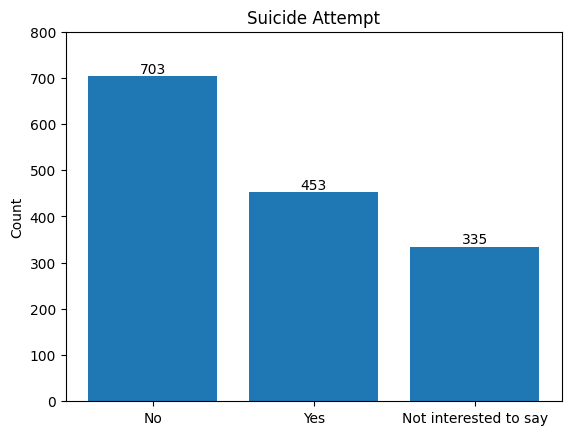

In [13]:
plt.style.use('default')
fig, ax = plt.subplots()
bar_container = ax.bar(df_suicide_attempt.index, df_suicide_attempt['suicide_attempt'])
ax.set(ylabel='Count', title='Suicide Attempt', ylim=(0, 800))
ax.bar_label(bar_container)


                      suicide_attempt
No                              47.1%
Yes                             30.4%
Not interested to say           22.5%


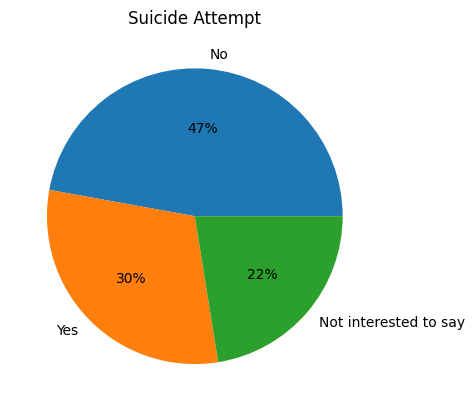

In [14]:
print(pd.DataFrame(df["suicide_attempt"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'))

labels = ['No', 'Yes', 'Not interested to say']

#create pie chart
plt.pie(df_suicide_attempt['suicide_attempt'], labels = labels, autopct='%.0f%%')
plt.title('Suicide Attempt')
plt.show()

**Conclusion**

* Among the respondents, 453 individuals reported suicide attempts, while the majority did not. Additionally, 335 respondents did not provide an answer to this question.
* The data indicates that approximately 30.4% of the respondents reported having attempted suicide.

&rarr; To comprehend the relationships associated with suicide attempts, I am investigating correlations. To facilitate this analysis, I will need to convert the column types into numeric values.

**Ordinal Encoding**

In [15]:
num_df = df.copy(deep=True)

In [16]:
# Let's change categorical variables to numeric values
yes_no_columns = ['feeling_sad_or_tearful', 'irritable_towards_baby_&_partner', 
                  'trouble_sleeping_at_night', 'problems_concentrating_or_making_decision',
                  'overeating_or_loss_of_appetite', 'feeling_anxious', 
                  'feeling_of_guilt', 'problems_of_bonding_with_baby', 
                  'suicide_attempt']
replace_dict = {
    'Yes': 1,
    'No': 0,
    'Sometimes': 2,
    'Two or more days a week': 2,
    'Often': 2,
    'Maybe': 2,
    'Not interested to say': 2,
    'Not at all': 2
}

for column in yes_no_columns:
    num_df[column] = num_df[column].replace(replace_dict)

num_df['age'] =  num_df['age'].replace({'25-30': 1, '30-35': 2, '35-40': 3, '40-45': 4, '45-50': 5})

    
num_df

,age,feeling_sad_or_tearful,irritable_towards_baby_&_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_anxious,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt
0,3,1,1,2,1,1,1,0,1,1
1,4,1,0,0,1,1,0,1,1,0
2,3,1,0,1,1,1,1,0,2,0
3,3,1,1,1,1,0,1,2,0,0
4,4,1,0,2,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1486,2,1,0,2,0,0,1,2,2,0
1487,1,2,0,0,2,0,1,2,1,0
1488,1,0,2,2,0,0,0,1,0,2
1489,1,0,2,1,2,0,1,0,0,0


In [17]:
num_df.dtypes

age                                          int64
feeling_sad_or_tearful                       int64
irritable_towards_baby_&_partner             int64
trouble_sleeping_at_night                    int64
problems_concentrating_or_making_decision    int64
overeating_or_loss_of_appetite               int64
feeling_anxious                              int64
feeling_of_guilt                             int64
problems_of_bonding_with_baby                int64
suicide_attempt                              int64
dtype: object

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'feeling_sad_or_tearful'}>,
        <AxesSubplot:title={'center':'irritable_towards_baby_&_partner'}>],
       [<AxesSubplot:title={'center':'trouble_sleeping_at_night'}>,
        <AxesSubplot:title={'center':'problems_concentrating_or_making_decision'}>,
        <AxesSubplot:title={'center':'overeating_or_loss_of_appetite'}>],
       [<AxesSubplot:title={'center':'feeling_anxious'}>,
        <AxesSubplot:title={'center':'feeling_of_guilt'}>,
        <AxesSubplot:title={'center':'problems_of_bonding_with_baby'}>],
       [<AxesSubplot:title={'center':'suicide_attempt'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

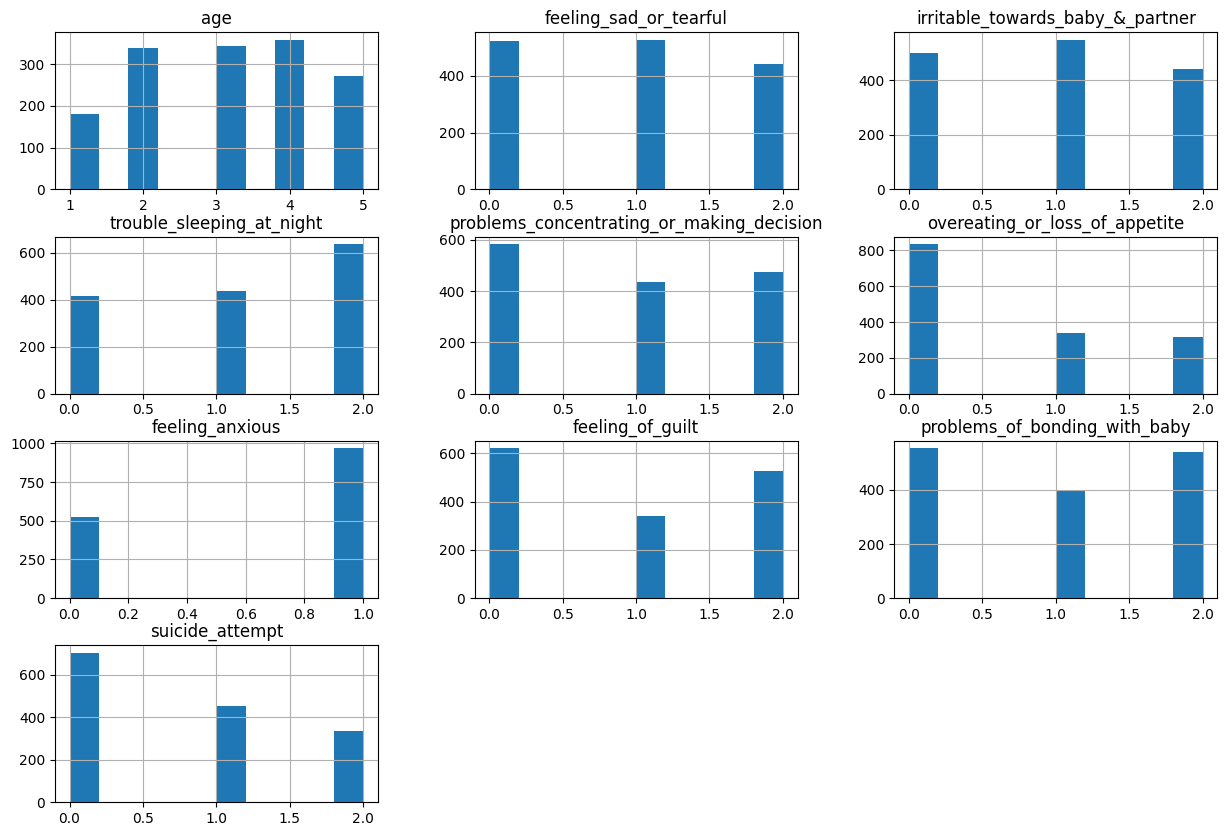

In [18]:
num_df.hist(figsize=(15,10))

**Correlation**

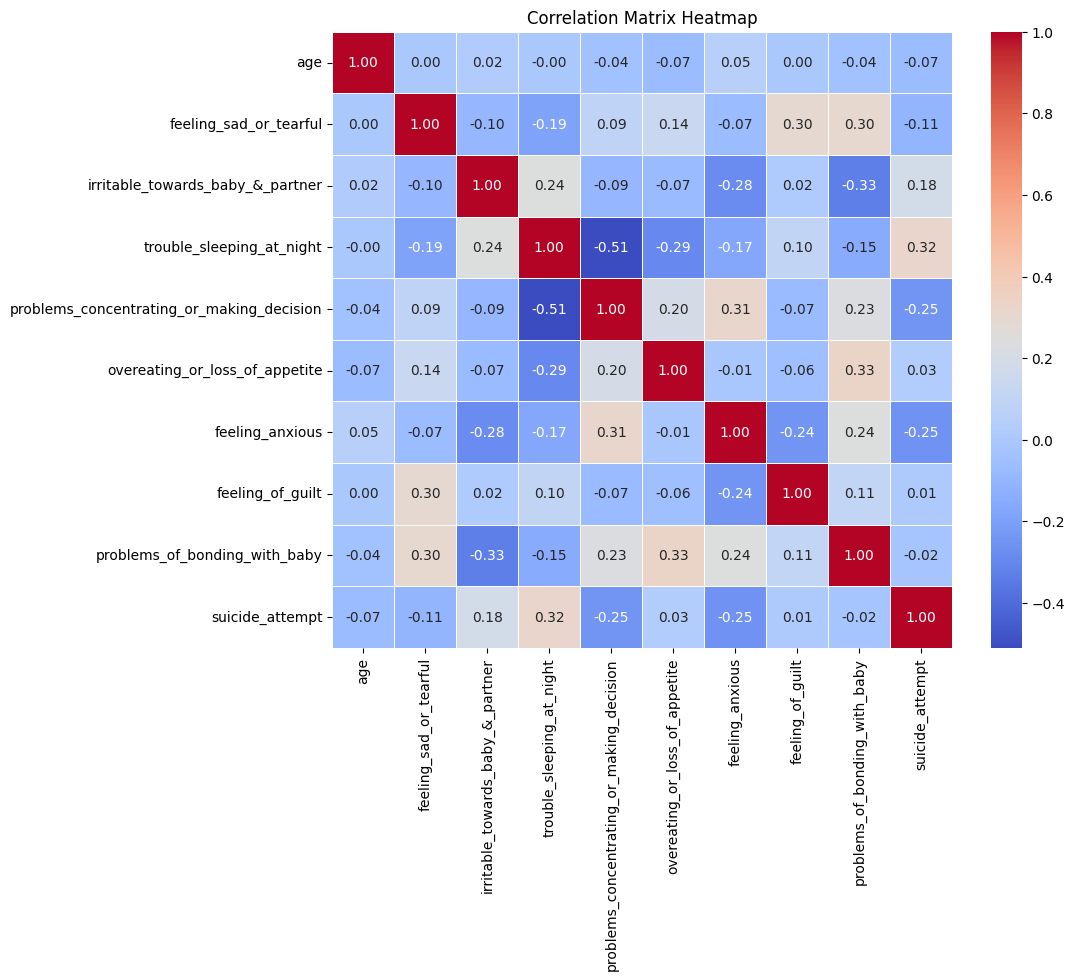

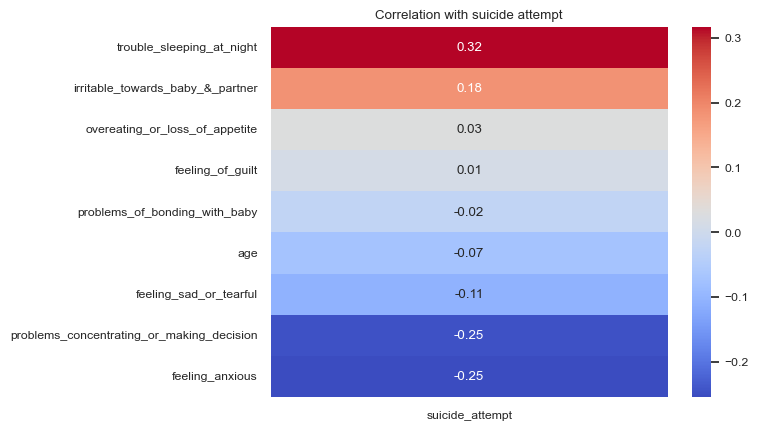

In [19]:
columns_to_include = ['age', 'feeling_sad_or_tearful', 'irritable_towards_baby_&_partner', 
                  'trouble_sleeping_at_night', 'problems_concentrating_or_making_decision',
                  'overeating_or_loss_of_appetite', 'feeling_anxious', 
                  'feeling_of_guilt', 'problems_of_bonding_with_baby', 
                  'suicide_attempt']
df_subset =  num_df[columns_to_include]

correlation_matrix = df_subset.corr()

# Plot 1
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

corr = df_subset.corr()
target_corr = corr['suicide_attempt'].drop('suicide_attempt')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

# Plot 2
# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with suicide attempt')
plt.show()

**The most influential indicators for suicide attampt:**

| Feature| Correlation |
| --- | ----------- |
| Trouble sleeping at night | 0.316 |
| Problems concentrating or making decision | -0.246 |
| Feeling anxious | -0.254 |

#### **Trouble sleeping at night**

,Count,Persent
Trouble sleeping at night,,
Two or more days a week,637,42.7%
Yes,439,29.4%
No,415,27.8%


Text(0.5, 1.0, 'Trouble sleeping at night')

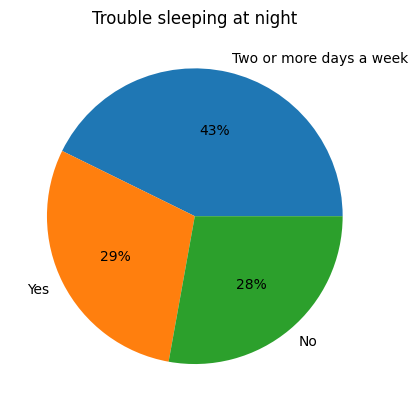

In [20]:
tsan = pd.DataFrame(df["trouble_sleeping_at_night"].value_counts())
tsan['trouble_sleeping_at_night_%'] = pd.DataFrame(
    df["trouble_sleeping_at_night"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
)
tsan.columns = ['Count', 'Persent']
tsan.index.rename('Trouble sleeping at night', inplace=True)

# Table
display(tsan)

# Plot
plt.style.use('default')
df.trouble_sleeping_at_night.value_counts().plot(kind='pie', autopct='%.0f%%', label='')
plt.title('Trouble sleeping at night')

In [21]:
bytrouble_sleeping = df.groupby("trouble_sleeping_at_night").suicide_attempt.value_counts()
bytrouble_sleeping_norm = df.groupby("trouble_sleeping_at_night").suicide_attempt.value_counts(normalize=True)
bytrounle_uns = bytrouble_sleeping.unstack()
bytrounle_uns.columns.name = 'Suicide Attempt'
bytrounle_uns.index.name = 'Trouble sleeping at night'

Suicide Attempt                              
                                       No Not interested to say     Yes
trouble_sleeping_at_night                                              
No                                  70.6%                 8.67%  20.72%
Two or more days a week             32.5%                32.34%  35.16%
Yes                                46.24%                21.18%  32.57%

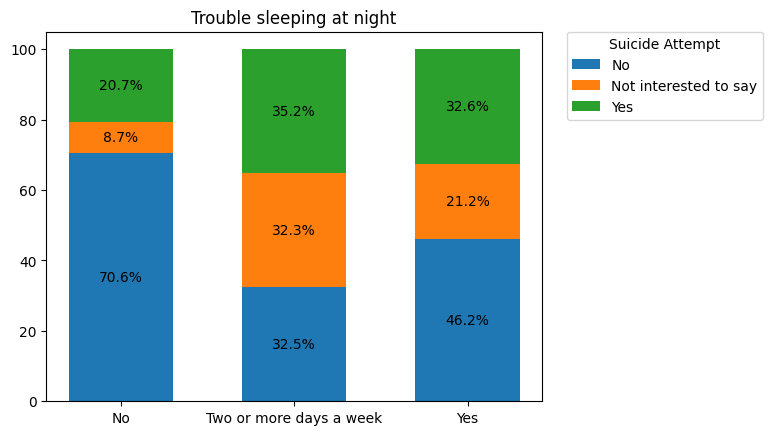

In [22]:
# Table
btsn = bytrouble_sleeping_norm.unstack().mul(100).round(2)
btsn_pr = btsn.astype(str) + '%'
make_table(btsn_pr)


# Plot
make_subplots(btsn, '%.1f%%', bottom = np.zeros(3), title = 'Trouble sleeping at night')
plt.style.use('default')


,Suicide Attempt|Yes
Trouble Sleeping at Night,
No,86
Two or more days a week,224
Yes,143


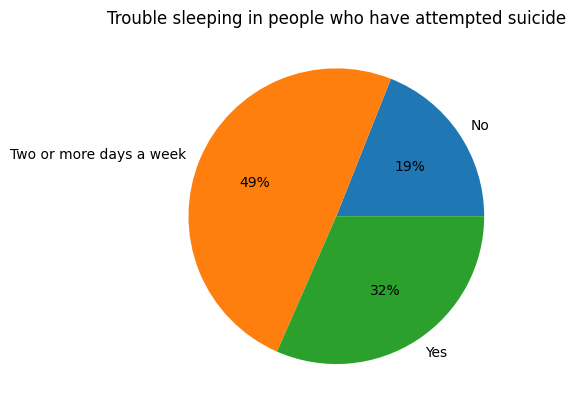

In [23]:
suicide_yes = bytrouble_sleeping.unstack().drop(['No', 'Not interested to say'], axis=1)
suicide_yes.columns = ['Suicide Attempt|Yes']
suicide_yes.index.name ='Trouble Sleeping at Night'
display(suicide_yes)



plt.pie(suicide_yes['Suicide Attempt|Yes'], labels=suicide_yes.index, autopct='%.0f%%')
plt.title('Trouble sleeping in people who have attempted suicide')
plt.show()

**Conclusion**

* **_Sleep Problems:_**

    * Around 43% of respondents experience occasional sleep problems.
    * Approximately 29% report facing chronic sleep issues.
    * About 28% do not encounter any sleep problems.
>

* **_Suicide Attempt and Sleep Problems:_**

    * Respondents who acknowledged a suicide attempt are most prevalent among those who experience intermittent sleep problems (35%).
    * Among those with sleep problems, approximately 32.6% have reported making suicide attempts.
    * The lowest suicide rate (20.7%) is observed among respondents without sleep problems.
    * Among individuals who have attempted suicide, 49% face occasional sleep problems, 32% experience sleep difficulties, and only 19% do not encounter sleep-related issues.

#### **Problems concentrating or making decision**

In [24]:
pcmd = pd.DataFrame(df['problems_concentrating_or_making_decision'].value_counts())
pcmd['problems_concentrating_or_making_decision_%'] = pd.DataFrame(
    df["problems_concentrating_or_making_decision"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
)
pcmd.columns = ['Count', 'Persent']
pcmd.index.rename('Problems concentrating or making decision', inplace=True)

,Count,Persent
Problems concentrating or making decision,,
No,583,39.1%
Often,473,31.7%
Yes,435,29.2%


Text(0.5, 1.0, 'Problems concentrating or making decision')

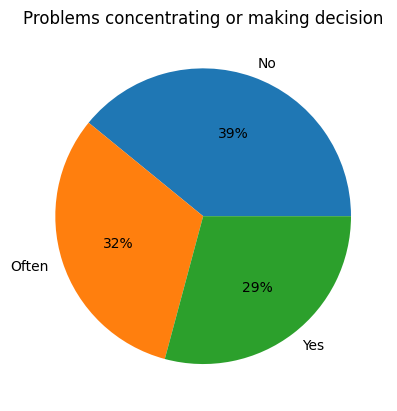

In [25]:
display(pcmd)


df.problems_concentrating_or_making_decision.value_counts().plot(kind='pie', autopct='%.0f%%', label='')
plt.title('Problems concentrating or making decision')

In [26]:
byproblems_concentrating = df.groupby("problems_concentrating_or_making_decision").suicide_attempt.value_counts()
byproblems_concentrating_norm = df.groupby("problems_concentrating_or_making_decision").suicide_attempt.value_counts(normalize=True)
byproblems_uns = byproblems_concentrating.unstack()
byproblems_uns.columns.name = 'Suicide Attempt'
byproblems_uns.index.name = 'Problems concentrating or making decision'

Suicide Attempt  \
                                                       No   
problems_concentrating_or_making_decision                   
No                                                 39.28%   
Often                                              73.36%   
Yes                                                 29.2%   

                                                                         
                                          Not interested to say     Yes  
problems_concentrating_or_making_decision                                
No                                                       28.64%  32.08%  
Often                                                    14.16%  12.47%  
Yes                                                      23.22%  47.59%

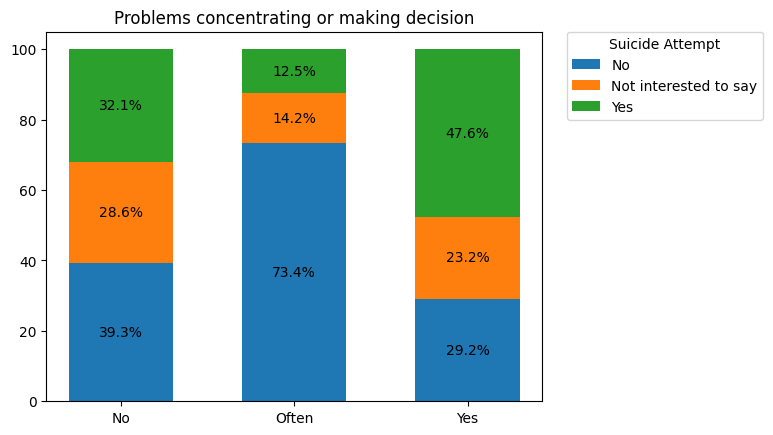

In [27]:
# Table
bpcn = byproblems_concentrating_norm.unstack().mul(100).round(2)
bpcn_pr = bpcn.astype(str) + '%'
make_table(bpcn_pr)


# Plot
make_subplots(bpcn, '%.1f%%', bottom = np.zeros(3), title = 'Problems concentrating or making decision')

,Suicide Attempt|Yes
Problems concentrating or making decision,
No,187
Often,59
Yes,207


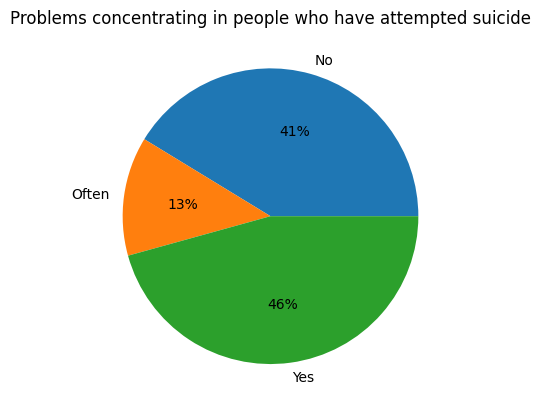

In [28]:
pcsy = byproblems_concentrating.unstack().drop(['No', 'Not interested to say'], axis=1)
pcsy.columns = ['Suicide Attempt|Yes']
pcsy.index.name ='Problems concentrating or making decision'
display(pcsy)

labels = ['No', 'Often', 'Yes']

plt.pie(pcsy['Suicide Attempt|Yes'], labels = labels, autopct='%.0f%%')
plt.title('Problems concentrating in people who have attempted suicide')
plt.show()

**Conclusion**

* ***Concentration and Decision-Making:***

    * Approximately 39% of respondents do not experience difficulties with concentration or decision-making.
    * About 32% of respondents frequently encounter problems with concentration or decision-making.
    * Around 29% of respondents face occasional issues with concentration or decision-making.
>
* ***Suicide Attempt and Concentration/Decision-Making:***

    * Half of the respondents who struggle with concentration or decision-making have attempted suicide.
    * Respondents who often experience difficulties with decision-making have the lowest number of reported suicide attempts.
    * Among those without concentration problems, approximately 32.1% have attempted suicide.
    * Among individuals who have attempted suicide, 46% report problems with concentration, 41% do not face concentration issues, and 13% frequently encounter problems with concentration.

#### **Feeling Anxious**

In [29]:
fa = pd.DataFrame(df["feeling_anxious"].value_counts())
fa['feeling_anxious_%'] = pd.DataFrame(
    df["feeling_anxious"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
)
fa.columns = ['Count', 'Persent']
fa.index.rename('feeling anxious', inplace=True)

,Count,Persent
feeling anxious,,
Yes,968,64.9%
No,523,35.1%


Text(0.5, 1.0, 'Feeling anxious')

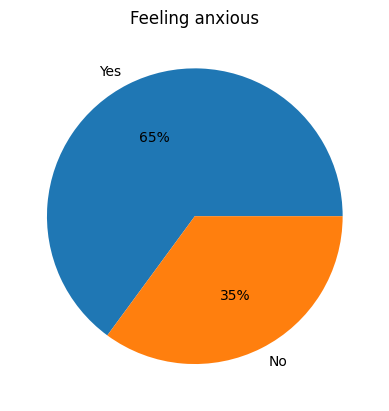

In [30]:
display(fa)


df.feeling_anxious.value_counts().plot(kind='pie', autopct='%.0f%%', label='')
plt.title('Feeling anxious')

In [31]:
byfeeling_anxious = df.groupby("feeling_anxious").suicide_attempt.value_counts()
byfeeling_anxious_norm = df.groupby("feeling_anxious").suicide_attempt.value_counts(normalize=True)
byfeeling_anxious_uns = byfeeling_anxious.unstack()
byfeeling_anxious_uns.columns.name = 'Suicide Attempt'
byfeeling_anxious_uns.index.name = 'Feeling anxious'

Suicide Attempt                              
                             No Not interested to say     Yes
feeling_anxious                                              
No                       36.33%                 39.2%  24.47%
Yes                       53.0%                13.43%  33.57%

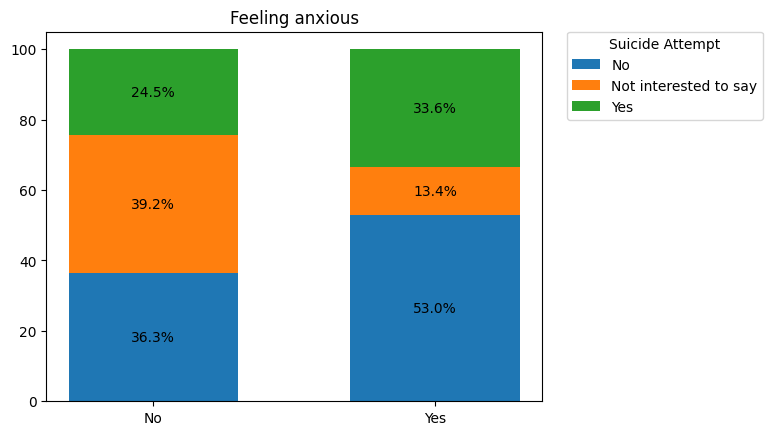

In [32]:
# Table
bfan = byfeeling_anxious_norm.unstack().mul(100).round(2)
bfan_pr = bfan.astype(str) + '%'
make_table(bfan_pr)


# Plot
make_subplots(bfan, '%.1f%%', bottom = np.zeros(2), title= 'Feeling anxious')

,Suicide Attempt|Yes
Feeling anxious,
No,128
Yes,325


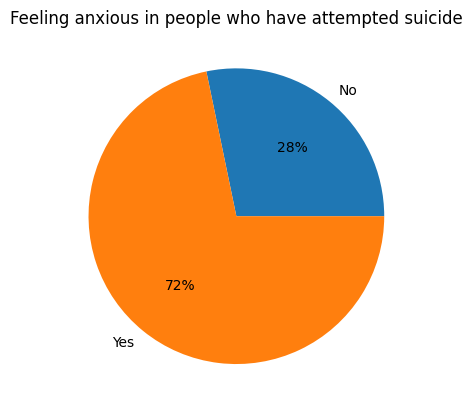

In [33]:
fasy = byfeeling_anxious.unstack().drop(['No', 'Not interested to say'], axis=1)
fasy.columns = ['Suicide Attempt|Yes']
fasy.index.name ='Feeling anxious'
display(fasy)

labels = ['No', 'Yes']

plt.pie(fasy['Suicide Attempt|Yes'], labels=labels, autopct='%.0f%%')
plt.title('Feeling anxious in people who have attempted suicide')
plt.show()

**Conclusion**


* Among the respondents, 65% report feeling anxious, while 35% do not experience feelings of anxiety.
* Among those who feel anxious, half did not attempt suicide, whereas 33.6% did make a suicide attempt.
* Among respondents who do not feel anxious, 24.5% have made suicide attempts.
* Among the respondents who attempted suicide, 72% report experiencing feelings of anxiety.

## Machine Learning Model

In [34]:
y =  num_df['suicide_attempt']

In [35]:
# Choosing Features
df_features = ['age', 'feeling_sad_or_tearful',
       'irritable_towards_baby_&_partner', 'trouble_sleeping_at_night',
       'problems_concentrating_or_making_decision',
       'overeating_or_loss_of_appetite', 'feeling_anxious', 'feeling_of_guilt',
       'problems_of_bonding_with_baby']

In [36]:
X =  num_df[df_features]

In [37]:
X.describe()

,age,feeling_sad_or_tearful,irritable_towards_baby_&_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_anxious,feeling_of_guilt,problems_of_bonding_with_baby
count,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.00000
mean,3.134138,0.947686,0.962441,1.148893,0.926224,0.651911,0.649229,0.937626,0.98994
std,1.289392,0.802646,0.794231,0.826956,0.838617,0.806992,0.477372,0.875927,0.85642
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.00000
75%,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.00000
max,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.00000


In [38]:
X.head()

,age,feeling_sad_or_tearful,irritable_towards_baby_&_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_anxious,feeling_of_guilt,problems_of_bonding_with_baby
0,3,1,1,2,1,1,1,0,1
1,4,1,0,0,1,1,0,1,1
2,3,1,0,1,1,1,1,0,2
3,3,1,1,1,1,0,1,2,0
4,4,1,0,2,1,0,1,0,1


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

### **Random Forest Classifier**

In [40]:
param_grid = {'max_depth' : range(3,15,1), 
              'min_samples_split': range(3,15,1),
              'n_estimators'     : [50, 100, 200] 
              }

In [41]:
rf_Grid = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv=5, n_jobs=4)

In [42]:
rf_Grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': range(3, 15),
                         'min_samples_split': range(3, 15),
                         'n_estimators': [50, 100, 200]})

In [43]:
rf_Grid.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=3)

In [44]:
y_pred = rf_Grid.best_estimator_.predict(X_test)

In [45]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[139   1   0]
 [  4  82   0]
 [  4   1  68]]
0.9665551839464883


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       140
           1       0.98      0.95      0.96        86
           2       1.00      0.93      0.96        73

    accuracy                           0.97       299
   macro avg       0.97      0.96      0.97       299
weighted avg       0.97      0.97      0.97       299



### Cross-validation

In [47]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(rf_Grid.best_estimator_, X_train, y_train, cv=cv)

print(f'Scores:\n{scores}\n')
print(f'Random Forest; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}')

Scores:
[0.9        0.95833333 0.97478992 0.95798319 0.90756303 0.94957983
 0.96638655 0.97478992 0.95798319 0.97478992 0.96666667 0.96666667
 0.96638655 0.94957983 0.96638655 0.96638655 0.94117647 0.93277311
 0.93277311 0.98319328 0.95833333 0.95833333 0.98319328 0.95798319
 0.96638655 0.97478992 0.97478992 0.93277311 0.92436975 0.94117647]

Random Forest; Cross-validation mean accuracy score and standard deviation: 0.956 +/-0.021


### Feature Importance

In [48]:
rf_Grid.best_estimator_.feature_importances_


array([0.08689954, 0.1293127 , 0.13045687, 0.13250373, 0.12399189,
       0.10593254, 0.06471896, 0.11702417, 0.1091596 ])

In [49]:
feature_importances = pd.DataFrame(rf_Grid.best_estimator_.feature_importances_, index = df_features).sort_values(by=0, ascending=False)
feature_importances.set_axis(['Feature Importances'], axis=1)

,Feature Importances
trouble_sleeping_at_night,0.132504
irritable_towards_baby_&_partner,0.130457
feeling_sad_or_tearful,0.129313
problems_concentrating_or_making_decision,0.123992
feeling_of_guilt,0.117024
problems_of_bonding_with_baby,0.109160
overeating_or_loss_of_appetite,0.105933
age,0.086900
feeling_anxious,0.064719


Text(0.5, 1.0, 'Feature Importances')

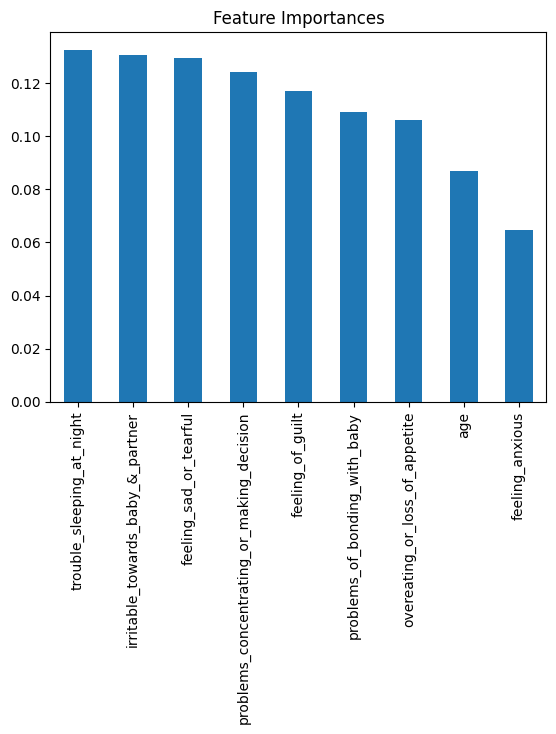

In [50]:
feature_importances.plot(kind='bar').get_legend().remove()
plt.title('Feature Importances')
